In [1]:
#importing necessary libraries
!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install missingno
!pip install chardet

In [2]:
#Use THE CHARDET library to detect the encoding of the dataset

import chardet

with open('Most Streamed Spotify Songs 2024.csv', 'rb') as file:
    result = chardet.detect(file.read(10000))  # Check a sample of the file
    print(result['encoding'])


ISO-8859-1


In [3]:
#Loading the dataset
spotify_songs=pd.read_csv('Most Streamed Spotify Songs 2024.csv', encoding='latin-1')


# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

print(spotify_songs)


                                Track                        Album Name  \
0                 MILLION DOLLAR BABY      Million Dollar Baby - Single   
1                         Not Like Us                       Not Like Us   
2          i like the way you kiss me        I like the way you kiss me   
3                             Flowers                  Flowers - Single   
4                             Houdini                           Houdini   
...                               ...                               ...   
4595                For the Last Time                 For the Last Time   
4596                 Dil Meri Na Sune  Dil Meri Na Sune (From "Genius")   
4597            Grace (feat. 42 Dugg)                           My Turn   
4598              Nashe Si Chadh Gayi             November Top 10 Songs   
4599  Me Acostumbre (feat. Bad Bunny)   Me Acostumbre (feat. Bad Bunny)   

              Artist Release Date          ISRC All Time Rank  Track Score  \
0      Tommy Richman 

In [4]:
#number of rows and columns
spotify_songs.shape

(4600, 29)

In [5]:
#General information of the dataset 
spotify_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   object 
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   object 
 8   Spotify Playlist Count      4530 non-null   object 
 9   Spotify Playlist Reach      4528 non-null   object 
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   object 
 12  YouTube Likes               4285 non-null   object 
 13  TikTok Posts                3427 

In [6]:
#checking the number of the columns
spotify_songs.columns

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity',
       'Explicit Track'],
      dtype='object')

## Data Cleaning

In [7]:
#Handling missing data
#Checking for total number of missing values in descending order
spotify_songs.isnull().sum().sort_values(ascending=False)

TIDAL Popularity              4600
Soundcloud Streams            3333
SiriusXM Spins                2123
Pandora Track Stations        1268
TikTok Posts                  1173
Pandora Streams               1106
Amazon Playlist Count         1055
YouTube Playlist Reach        1009
TikTok Views                   981
TikTok Likes                   980
Deezer Playlist Reach          928
Deezer Playlist Count          921
Spotify Popularity             804
Shazam Counts                  577
Apple Music Playlist Count     561
AirPlay Spins                  498
YouTube Likes                  315
YouTube Views                  308
Spotify Streams                113
Spotify Playlist Reach          72
Spotify Playlist Count          70
Artist                           5
All Time Rank                    0
Track Score                      0
ISRC                             0
Track                            0
Album Name                       0
Release Date                     0
Explicit Track      

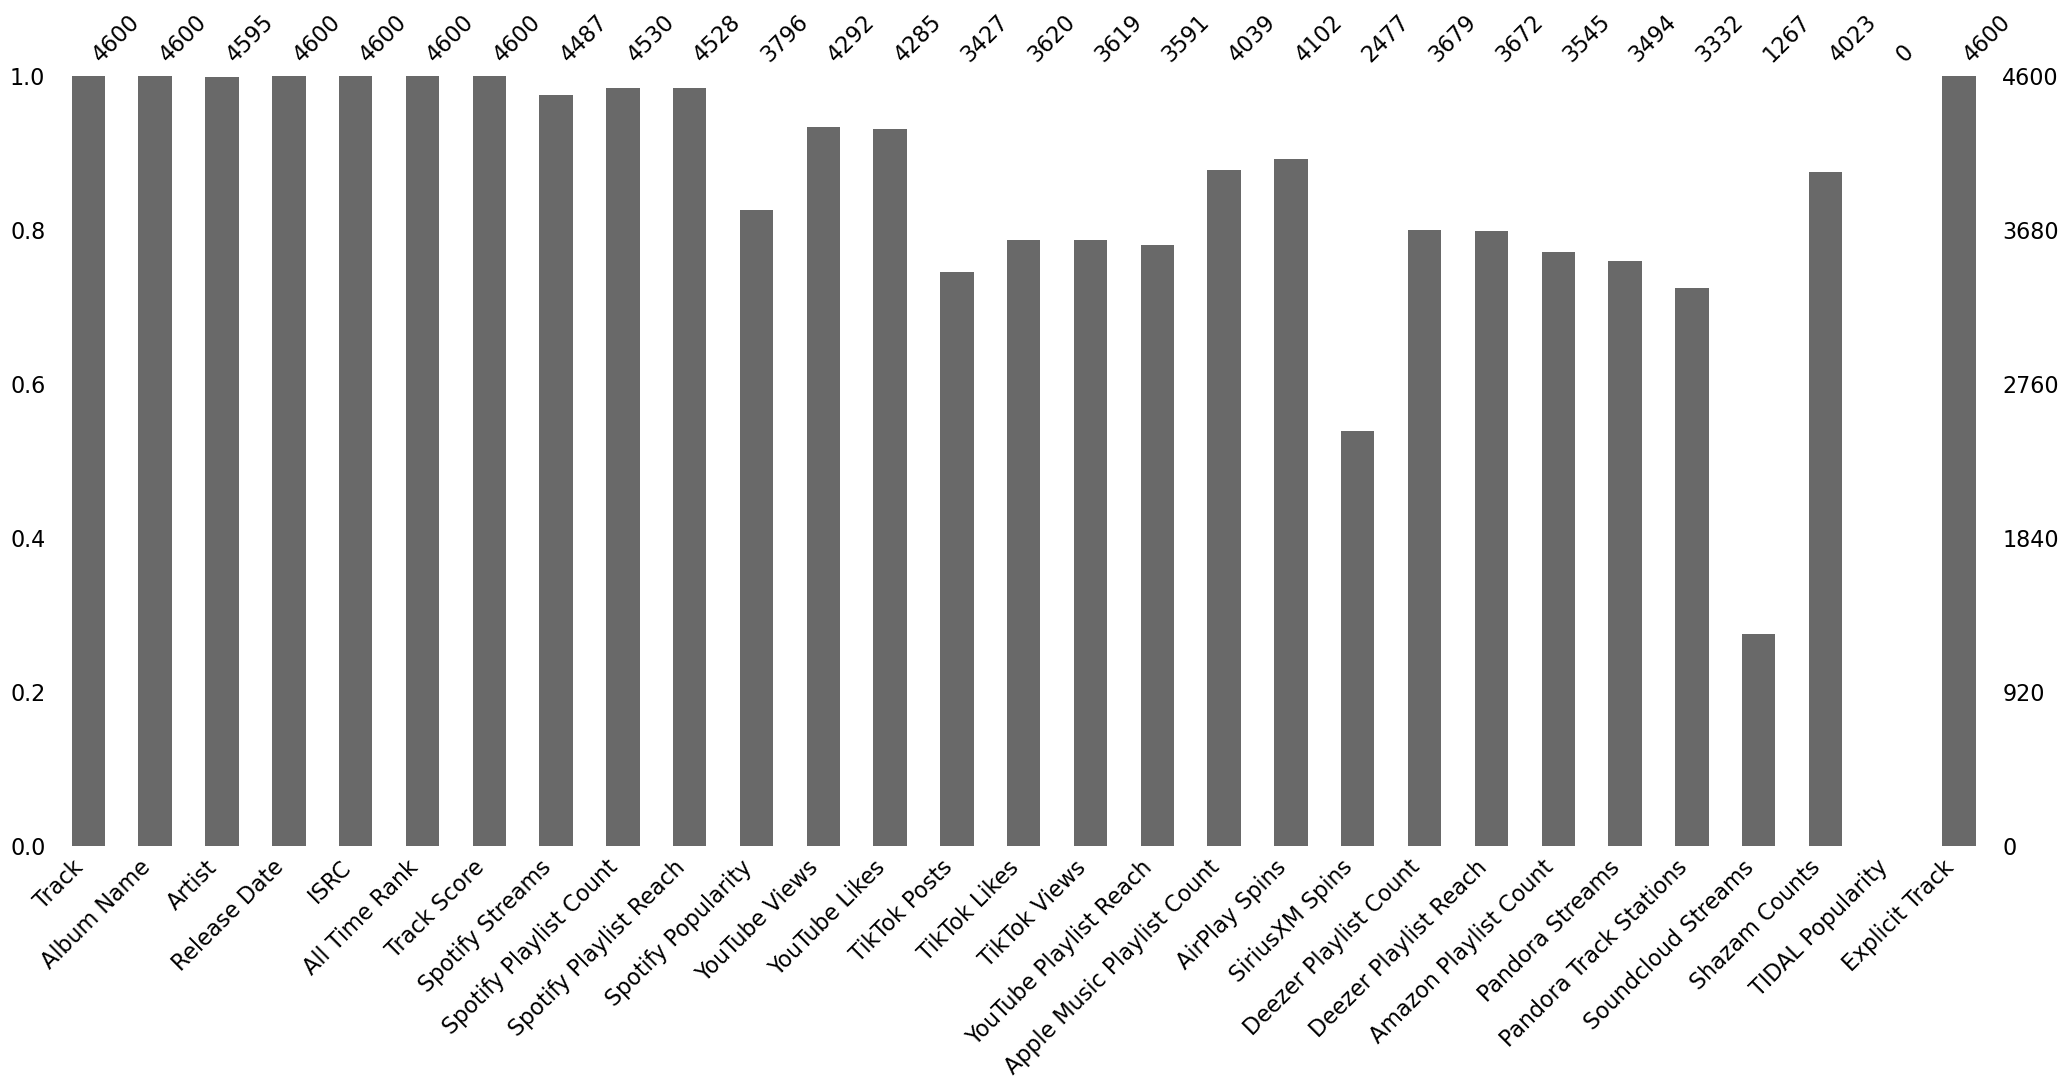

In [8]:

import missingno as msno

msno.bar(spotify_songs)
plt.show()

In [9]:
#dropping irrelevant columns

spotify_songs.drop('ISRC', axis = 1, inplace = True)
spotify_songs.drop('TIDAL Popularity', axis=1, inplace = True)
spotify_songs.drop('Soundcloud Streams', axis =1, inplace = True)

spotify_songs.columns

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'All Time Rank',
       'Track Score', 'Spotify Streams', 'Spotify Playlist Count',
       'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views',
       'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views',
       'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins',
       'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Shazam Counts', 'Explicit Track'],
      dtype='object')

In [10]:
spotify_songs.isnull().sum().sort_values(ascending=False)

SiriusXM Spins                2123
Pandora Track Stations        1268
TikTok Posts                  1173
Pandora Streams               1106
Amazon Playlist Count         1055
YouTube Playlist Reach        1009
TikTok Views                   981
TikTok Likes                   980
Deezer Playlist Reach          928
Deezer Playlist Count          921
Spotify Popularity             804
Shazam Counts                  577
Apple Music Playlist Count     561
AirPlay Spins                  498
YouTube Likes                  315
YouTube Views                  308
Spotify Streams                113
Spotify Playlist Reach          72
Spotify Playlist Count          70
Artist                           5
All Time Rank                    0
Album Name                       0
Track                            0
Release Date                     0
Track Score                      0
Explicit Track                   0
dtype: int64

In [11]:
#Removing duplicates

spotify_songs.duplicated().sum()

np.int64(2)

In [12]:
spotify_songs = spotify_songs.drop_duplicates(keep = 'first')
spotify_songs.duplicated().sum()

np.int64(0)

In [13]:
spotify_songs = spotify_songs.map(lambda x: x.replace(',', '') if isinstance(x, str) else x)
spotify_songs.head(20)

,Track,Album Name,Artist,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,TikTok Likes,TikTok Views,YouTube Playlist Reach,Apple Music Playlist Count,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Shazam Counts,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,1,725.4,390470936,30716,196631588,92.0,84274754,1713126,5767700,651565900,5332281936,150597040,210.0,40975,684,62.0,17598718,114.0,18004655,22931,2669262,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,2,545.9,323703884,28113,174597137,92.0,116347040,3486739,674700,35223547,208339025,156380351,188.0,40778,3,67.0,10422430,111.0,7780028,28444,1118279,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,3,538.4,601309283,54331,211607669,92.0,122599116,2228730,3025400,275154237,3369120610,373784955,190.0,74333,536,136.0,36321847,172.0,5022621,5639,5285340,0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,4,444.9,2031280633,269802,136569078,85.0,1096100899,10629796,7189811,1078757968,14603725994,3351188582,394.0,1474799,2182,264.0,24684248,210.0,190260277,203384,11822942,0
4,Houdini,Houdini,Eminem,5/31/2024,5,423.3,107034922,7223,151469874,88.0,77373957,3670188,16400,NaN,NaN,112763851,182.0,12185,1,82.0,17660624,105.0,4493884,7006,457017,1
5,Lovin On Me,Lovin On Me,Jack Harlow,11/10/2023,6,410.1,670665438,105892,175421034,83.0,131148091,1392593,4202367,214943489,2938686633,2867222632,138.0,522042,4654,86.0,17167254,152.0,138529362,50982,4517131,1
6,Beautiful Things,Beautiful Things,Benson Boone,1/18/2024,7,407.2,900158751,73118,201585714,86.0,308723145,4120760,NaN,29584940,534915313,4601579812,280.0,383478,429,168.0,48197850,154.0,65447476,57372,9990302,0
7,Gata Only,Gata Only,FloyyMenor,2/2/2024,8,375.8,675079153,40094,211236940,92.0,228382568,1439495,3500000,338546668,3804584163,2112581620,160.0,17221,30,87.0,33245595,53.0,3372428,5762,6063523,1
8,Danza Kuduro - Cover,ýýýýýýýýýýýýýýýýýýýýý - ýýýýýýýýýýýýýýýýýý -,MUSIC LAB JPN,6/9/2024,9,355.7,1653018119,1,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,BAND4BAND (feat. Lil Baby),BAND4BAND (feat. Lil Baby),Central Cee,5/23/2024,10,330.6,90676573,10400,184199419,86.0,32735244,988682,325800,121574500,974656200,174706874,191.0,3823,117,78.0,10800098,92.0,1005626,842,666302,1


In [14]:
#Converting Release Date to datetime format
spotify_songs['Release Date'] = pd.to_datetime(spotify_songs['Release Date'], format = '%m/%d/%Y')

spotify_songs['Year'] = spotify_songs['Release Date'].dt.year
spotify_songs['Month'] = spotify_songs['Release Date'].dt.month

In [15]:
#Mean Imputation to handle missing numerical values
columns_to_impute = spotify_songs.columns[6:]

# Convert the selected columns to numeric, coercing errors to NaN
spotify_songs[columns_to_impute] = spotify_songs[columns_to_impute].apply(pd.to_numeric, errors='coerce')

# Impute missing values with the mean for the selected columns
spotify_songs[columns_to_impute] = spotify_songs[columns_to_impute].fillna(spotify_songs[columns_to_impute].mean())

spotify_songs.replace([float('inf'), -float('inf')], pd.NA, inplace=True)


# Print the count of missing values in each column
print(spotify_songs.isnull().sum())


Track                         0
Album Name                    0
Artist                        5
Release Date                  0
All Time Rank                 0
Track Score                   0
Spotify Streams               0
Spotify Playlist Count        0
Spotify Playlist Reach        0
Spotify Popularity            0
YouTube Views                 0
YouTube Likes                 0
TikTok Posts                  0
TikTok Likes                  0
TikTok Views                  0
YouTube Playlist Reach        0
Apple Music Playlist Count    0
AirPlay Spins                 0
SiriusXM Spins                0
Deezer Playlist Count         0
Deezer Playlist Reach         0
Amazon Playlist Count         0
Pandora Streams               0
Pandora Track Stations        0
Shazam Counts                 0
Explicit Track                0
Year                          0
Month                         0
dtype: int64


In [16]:
spotify_songs.head(10)

,Track,Album Name,Artist,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,TikTok Likes,TikTok Views,YouTube Playlist Reach,Apple Music Playlist Count,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Shazam Counts,Explicit Track,Year,Month
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,2024-04-26,1,725.4,3.904709e+08,30716.0,196631588.0,92.000000,8.427475e+07,1.713126e+06,5.767700e+06,6.515659e+08,5.332282e+09,1.505970e+08,210.000000,40975.00,684.000000,62.00000,1.759872e+07,114.000000,1.800466e+07,22931.000000,2.669262e+06,0,2024,4
1,Not Like Us,Not Like Us,Kendrick Lamar,2024-05-04,2,545.9,3.237039e+08,28113.0,174597137.0,92.000000,1.163470e+08,3.486739e+06,6.747000e+05,3.522355e+07,2.083390e+08,1.563804e+08,188.000000,40778.00,3.000000,67.00000,1.042243e+07,111.000000,7.780028e+06,28444.000000,1.118279e+06,1,2024,5
2,i like the way you kiss me,I like the way you kiss me,Artemas,2024-03-19,3,538.4,6.013093e+08,54331.0,211607669.0,92.000000,1.225991e+08,2.228730e+06,3.025400e+06,2.751542e+08,3.369121e+09,3.737850e+08,190.000000,74333.00,536.000000,136.00000,3.632185e+07,172.000000,5.022621e+06,5639.000000,5.285340e+06,0,2024,3
3,Flowers,Flowers - Single,Miley Cyrus,2023-01-12,4,444.9,2.031281e+09,269802.0,136569078.0,85.000000,1.096101e+09,1.062980e+07,7.189811e+06,1.078758e+09,1.460373e+10,3.351189e+09,394.000000,1474799.00,2182.000000,264.00000,2.468425e+07,210.000000,1.902603e+08,203384.000000,1.182294e+07,0,2023,1
4,Houdini,Houdini,Eminem,2024-05-31,5,423.3,1.070349e+08,7223.0,151469874.0,88.000000,7.737396e+07,3.670188e+06,1.640000e+04,1.126902e+08,1.161724e+09,1.127639e+08,182.000000,12185.00,1.000000,82.00000,1.766062e+07,105.000000,4.493884e+06,7006.000000,4.570170e+05,1,2024,5
5,Lovin On Me,Lovin On Me,Jack Harlow,2023-11-10,6,410.1,6.706654e+08,105892.0,175421034.0,83.000000,1.311481e+08,1.392593e+06,4.202367e+06,2.149435e+08,2.938687e+09,2.867223e+09,138.000000,522042.00,4654.000000,86.00000,1.716725e+07,152.000000,1.385294e+08,50982.000000,4.517131e+06,1,2023,11
6,Beautiful Things,Beautiful Things,Benson Boone,2024-01-18,7,407.2,9.001588e+08,73118.0,201585714.0,86.000000,3.087231e+08,4.120760e+06,9.448117e+05,2.958494e+07,5.349153e+08,4.601580e+09,280.000000,383478.00,429.000000,168.00000,4.819785e+07,154.000000,6.544748e+07,57372.000000,9.990302e+06,0,2024,1
7,Gata Only,Gata Only,FloyyMenor,2024-02-02,8,375.8,6.750792e+08,40094.0,211236940.0,92.000000,2.283826e+08,1.439495e+06,3.500000e+06,3.385467e+08,3.804584e+09,2.112582e+09,160.000000,17221.00,30.000000,87.00000,3.324560e+07,53.000000,3.372428e+06,5762.000000,6.063523e+06,1,2024,2
8,Danza Kuduro - Cover,ýýýýýýýýýýýýýýýýýýýýý - ýýýýýýýýýýýýýýýýýý -,MUSIC LAB JPN,2024-06-09,9,355.7,1.653018e+09,1.0,15.0,63.498682,4.027841e+08,2.930659e+06,9.448117e+05,1.126902e+08,1.161724e+09,3.440298e+08,54.613574,55133.23,257.534949,32.32173,1.295634e+06,25.346034,8.569817e+07,87919.294294,2.529828e+06,1,2024,6
9,BAND4BAND (feat. Lil Baby),BAND4BAND (feat. Lil Baby),Central Cee,2024-05-23,10,330.6,9.067657e+07,10400.0,184199419.0,86.000000,3.273524e+07,9.886820e+05,3.258000e+05,1.215745e+08,9.746562e+08,1.747069e+08,191.000000,3823.00,117.000000,78.00000,1.080010e+07,92.000000,1.005626e+06,842.000000,6.663020e+05,1,2024,5


In [17]:
spotify_songs['Release Date']

0      2024-04-26
1      2024-05-04
2      2024-03-19
3      2023-01-12
4      2024-05-31
          ...    
4595   2017-09-05
4596   2018-07-27
4597   2020-02-28
4598   2016-11-08
4599   2017-04-11
Name: Release Date, Length: 4598, dtype: datetime64[ns]

In [18]:
#Statistical Summary of the dataset
spotify_songs.describe()

,Release Date,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,TikTok Likes,TikTok Views,YouTube Playlist Reach,Apple Music Playlist Count,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Shazam Counts,Explicit Track,Year,Month
count,4598,4598.000000,4.598000e+03,4598.000000,4.598000e+03,4598.000000,4.598000e+03,4.598000e+03,4.598000e+03,4.598000e+03,4.598000e+03,4.598000e+03,4598.000000,4.598000e+03,4598.000000,4598.000000,4.598000e+03,4598.000000,4.598000e+03,4.598000e+03,4.598000e+03,4598.000000,4598.000000,4598.000000
mean,2021-01-27 10:44:50.213136128,41.850892,4.474069e+08,59397.509496,2.335177e+07,63.498682,4.027841e+08,2.930659e+06,9.448117e+05,1.126902e+08,1.161724e+09,3.440298e+08,54.613574,5.513323e+04,257.534949,32.321730,1.295634e+06,25.346034,8.569817e+07,8.791929e+04,2.529828e+06,0.359069,2020.617225,6.044367
min,1987-07-21 00:00:00,19.400000,1.071000e+03,1.000000,1.000000e+00,1.000000,9.130000e+02,2.500000e+01,1.000000e+00,3.000000e+00,1.900000e+01,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,2.000000e+00,1.000000e+00,1.000000e+00,0.000000,1987.000000,1.000000
25%,2019-07-17 06:00:00,23.300000,7.315308e+07,7017.250000,4.896219e+06,62.000000,4.576491e+07,4.486530e+05,6.742500e+04,9.398120e+06,9.362825e+07,2.255487e+07,12.000000,7.072500e+02,74.000000,7.000000,8.346800e+04,10.000000,2.599863e+06,2.730000e+03,2.884645e+05,0.000000,2019.000000,3.000000
50%,2022-06-01 00:00:00,29.900000,2.512982e+08,33366.000000,1.358052e+07,65.000000,1.735633e+08,1.467590e+06,4.785095e+05,5.479576e+07,5.109750e+08,1.952718e+08,36.000000,1.010650e+04,257.534949,24.000000,4.442245e+05,25.346034,4.278828e+07,3.045850e+04,1.175206e+06,0.000000,2022.000000,6.000000
75%,2023-08-11 00:00:00,44.475000,6.118920e+08,84952.750000,2.931328e+07,71.000000,4.202808e+08,3.354939e+06,9.448117e+05,1.126902e+08,1.161724e+09,3.440298e+08,60.000000,5.513323e+04,257.534949,32.321730,1.295634e+06,28.000000,8.569817e+07,8.791929e+04,2.529828e+06,1.000000,2023.000000,9.000000
max,2024-06-14 00:00:00,725.400000,4.281469e+09,590392.000000,2.623434e+08,96.000000,1.632276e+10,6.231118e+07,4.290000e+07,2.347422e+10,2.332323e+11,7.289707e+09,859.000000,1.777811e+06,7098.000000,632.000000,4.819785e+07,210.000000,1.463624e+09,3.780513e+06,2.197945e+08,1.000000,2024.000000,12.000000
std,NaN,38.550706,5.318901e+08,70601.843092,2.945935e+07,14.706175,6.780854e+08,4.434309e+06,2.108145e+06,4.878293e+08,5.217803e+09,5.925052e+08,67.115680,1.208127e+05,407.092998,48.545251,3.177208e+06,22.816344,1.463327e+08,2.220432e+05,5.648424e+06,0.479780,3.612041,3.419001


## Feature Engineering
### From the dataset, we can extract columns related to track, artist, release date, Spotify streams, and popularity metrics

In [19]:
#Data Transformation
# Extract relevant columns
features = spotify_songs[['Track', 'Album Name', 'Artist', 'Release Date', 'Spotify Streams', 'Spotify Popularity', 
               'YouTube Views', 'TikTok Views', 'Shazam Counts','Explicit Track','Year']]

# Check the data types and null values
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4598 entries, 0 to 4599
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Track               4598 non-null   object        
 1   Album Name          4598 non-null   object        
 2   Artist              4593 non-null   object        
 3   Release Date        4598 non-null   datetime64[ns]
 4   Spotify Streams     4598 non-null   float64       
 5   Spotify Popularity  4598 non-null   float64       
 6   YouTube Views       4598 non-null   float64       
 7   TikTok Views        4598 non-null   float64       
 8   Shazam Counts       4598 non-null   float64       
 9   Explicit Track      4598 non-null   int64         
 10  Year                4598 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(3)
memory usage: 413.1+ KB


### Create New Features
#### Streaming Velocity
Calculating the streaming velocity (Spotify streams per year), compute the difference between the current year and the release year

In [20]:
from datetime import datetime

# Create an explicit copy of the DataFrame slice
features = spotify_songs[['Track', 'Album Name', 'Artist', 'Release Date', 'Spotify Streams', 
               'Spotify Popularity', 'YouTube Views', 'TikTok Views', 'Shazam Counts','Explicit Track', 'Year']].copy()

# Calculate the current year
current_year = datetime.now().year


# Calculate the number of years since the song was released
features['Years Since Release'] = current_year - spotify_songs['Year'].copy()

# Avoid division by zero for songs released this year
features['Years Since Release'].replace(0, 1, inplace=True)

# Calculate streaming velocity (Spotify Streams per year)
features['Spotify Streaming Velocity'] = features['Spotify Streams'] / features['Years Since Release']

features.replace([float('inf'), -float('inf')], pd.NA, inplace=True)


# View the updated features
features[['Track', 'Artist', 'Spotify Streams', 'Years Since Release', 'Spotify Streaming Velocity']].head(10)


,Track,Artist,Spotify Streams,Years Since Release,Spotify Streaming Velocity
0,MILLION DOLLAR BABY,Tommy Richman,3.904709e+08,1,3.904709e+08
1,Not Like Us,Kendrick Lamar,3.237039e+08,1,3.237039e+08
2,i like the way you kiss me,Artemas,6.013093e+08,1,6.013093e+08
3,Flowers,Miley Cyrus,2.031281e+09,1,2.031281e+09
4,Houdini,Eminem,1.070349e+08,1,1.070349e+08
5,Lovin On Me,Jack Harlow,6.706654e+08,1,6.706654e+08
6,Beautiful Things,Benson Boone,9.001588e+08,1,9.001588e+08
7,Gata Only,FloyyMenor,6.750792e+08,1,6.750792e+08
8,Danza Kuduro - Cover,MUSIC LAB JPN,1.653018e+09,1,1.653018e+09
9,BAND4BAND (feat. Lil Baby),Central Cee,9.067657e+07,1,9.067657e+07


### Cross-Platform Presence
Creating a new feature for cross-platform presence by summing views across YouTube, TikTok, Shazam,

In [21]:
# Calculating cross-platform presence (total views and reach across YouTube, TikTok, and Shazam)
features['Cross-Platform Presence'] = features['YouTube Views'] + features['TikTok Views'] + features['Shazam Counts']

# View the updated features
features[['Track', 'Artist', 'YouTube Views', 'TikTok Views', 'Shazam Counts', 'Cross-Platform Presence']].head(10)


,Track,Artist,YouTube Views,TikTok Views,Shazam Counts,Cross-Platform Presence
0,MILLION DOLLAR BABY,Tommy Richman,8.427475e+07,5.332282e+09,2.669262e+06,5.419226e+09
1,Not Like Us,Kendrick Lamar,1.163470e+08,2.083390e+08,1.118279e+06,3.258043e+08
2,i like the way you kiss me,Artemas,1.225991e+08,3.369121e+09,5.285340e+06,3.497005e+09
3,Flowers,Miley Cyrus,1.096101e+09,1.460373e+10,1.182294e+07,1.571165e+10
4,Houdini,Eminem,7.737396e+07,1.161724e+09,4.570170e+05,1.239555e+09
5,Lovin On Me,Jack Harlow,1.311481e+08,2.938687e+09,4.517131e+06,3.074352e+09
6,Beautiful Things,Benson Boone,3.087231e+08,5.349153e+08,9.990302e+06,8.536288e+08
7,Gata Only,FloyyMenor,2.283826e+08,3.804584e+09,6.063523e+06,4.039030e+09
8,Danza Kuduro - Cover,MUSIC LAB JPN,4.027841e+08,1.161724e+09,2.529828e+06,1.567037e+09
9,BAND4BAND (feat. Lil Baby),Central Cee,3.273524e+07,9.746562e+08,6.663020e+05,1.008058e+09


### Data Aggregation
a. Group by Artist
Calculating the total streams, average popularity, and cross-platform reach for each artist:

In [22]:
# Group by artist and calculate total streams, average popularity, and total cross-platform presence
artist_agg = features.groupby('Artist').agg({'Spotify Streams': 'sum','Spotify Popularity': 'mean',
                                             'Cross-Platform Presence': 'sum'}).reset_index()

# View the aggregated data
artist_agg.columns = ['Artist', 'Total Spotify Streams', 'Average Spotify Popularity', 'Total Cross-Platform Presence']
artist_agg.head(10)

,Artist,Total Spotify Streams,Average Spotify Popularity,Total Cross-Platform Presence
0,"""XY""",4.474069e+08,63.498682,1.579413e+09
1,$OHO BANI,5.406556e+07,73.000000,1.168666e+09
2,$uicideboy$,1.697447e+09,70.055409,4.397284e+09
3,&ME,3.460163e+07,65.000000,4.046433e+08
4,(G)I-DLE,8.769385e+08,67.124671,4.622927e+09
5,*NSYNC,6.904186e+07,63.498682,8.584318e+07
6,.diedlonely,4.423587e+07,66.000000,1.782068e+09
7,10CM,1.880072e+07,73.000000,1.169316e+09
8,13 Organisï¿,2.672419e+08,63.000000,5.300840e+08
9,1da Banton,1.540100e+08,63.000000,9.657981e+08


In [23]:
# Group by Album Name and calculate total streams, average popularity, and total cross-platform presence
artist_agg = features.groupby('Album Name').agg({'Spotify Streams': 'sum','Spotify Popularity': 'mean',
                                             'Cross-Platform Presence': 'sum'}).reset_index()

# View the aggregated data
artist_agg.columns = ['Album Name', 'Total Spotify Streams', 'Average Spotify Popularity', 'Total Cross-Platform Presence']
artist_agg.head(10)

,Album Name,Total Spotify Streams,Average Spotify Popularity,Total Cross-Platform Presence
0,""" PARAM PARAM """,4.474069e+08,63.498682,1.667771e+09
1,"""ýýýýýý ýýýýýýýýýý ""ýýýýýýýýýýýý ýýýý ýýýýýýýý...",7.383901e+06,48.000000,4.391223e+08
2,#1 - EP,7.082704e+07,73.000000,2.363741e+09
3,#BrooklynBloodPop!,2.890855e+08,62.000000,2.436170e+09
4,#NAME?,5.008276e+09,68.800000,7.905730e+09
5,$AD BOYZ 4 LIFE II,6.299440e+08,79.500000,3.654856e+08
6,'Til You Canï¿½ï¿½ï¿½t / Longer Than S,2.587696e+08,68.000000,2.627914e+08
7,(It Goes Like) Nanana [Edit],4.601561e+08,77.000000,1.050262e+09
8,(Un)Commentary,2.034178e+08,66.000000,7.568417e+08
9,...And You Don't Stop - A Celebration of 50 Ye...,1.666700e+09,13.000000,1.567037e+09


In [24]:
# Group by explicit content and calculate average streams and popularity

explicit_agg = features.groupby('Explicit Track').agg({'Spotify Streams': 'mean','Spotify Popularity': 'mean'
                                                      }).reset_index()
# View the aggregated data
explicit_agg.columns = ['Explicit Track', 'Average Spotify Streams', 'Average Spotify Popularity']
explicit_agg.head()



,Explicit Track,Average Spotify Streams,Average Spotify Popularity
0,0,4.485530e+08,62.759517
1,1,4.453611e+08,64.818076


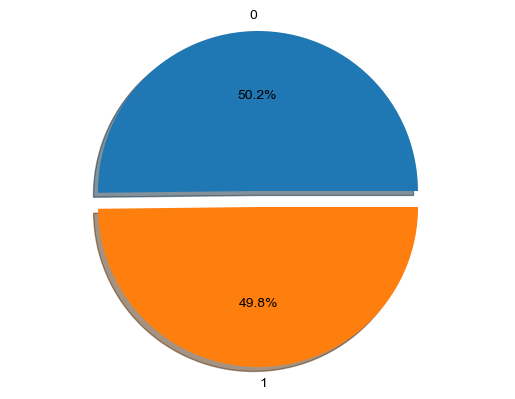

In [25]:

Explicit_content= features.groupby('Explicit Track')['Spotify Streams'].mean()

plt.pie(Explicit_content, labels= Explicit_content.index, autopct= '%1.1f%%', explode=[0.1, 0], shadow= True)

plt.axis('equal')
sns.set_style('darkgrid')
plt.show()

# Top 10 Most streamed Spotify Songs

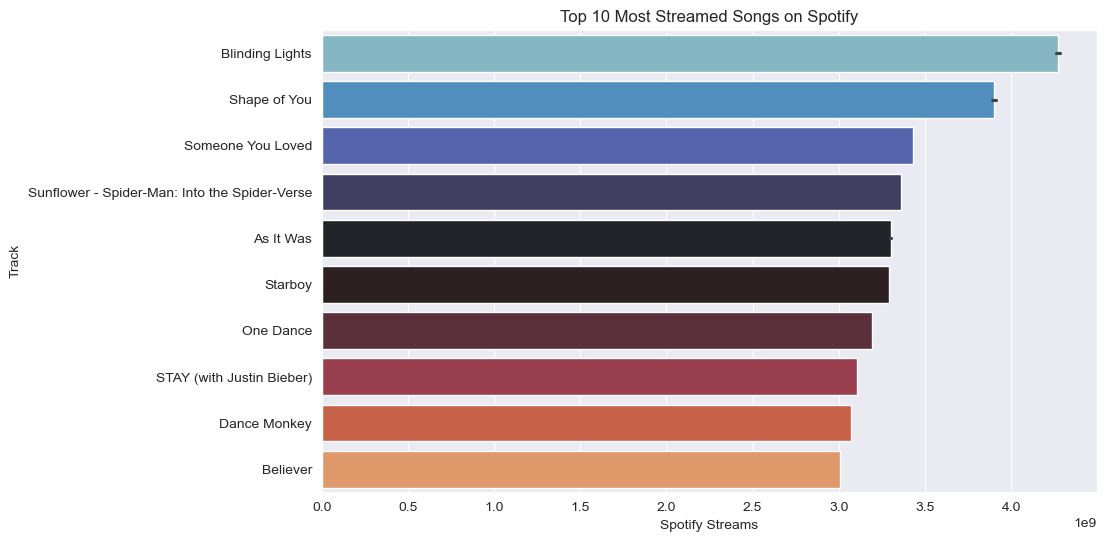

In [26]:


top_songs = features.sort_values(by='Spotify Streams', ascending=False).head(14)

plt.figure(figsize=(10, 6))
sns.barplot(x='Spotify Streams', y='Track', data= top_songs, palette="icefire")

plt.title('Top 10 Most Streamed Songs on Spotify')
plt.xlabel('Spotify Streams')
plt.ylabel('Track')
plt.show()


## Top Artists by Total Streams

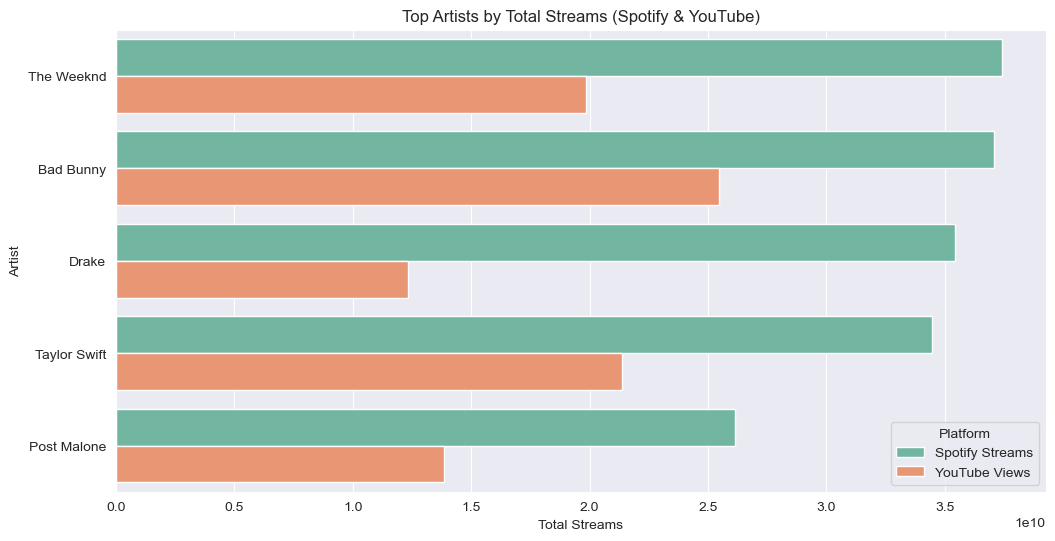

In [27]:

top_artists = features.groupby('Artist')[['Spotify Streams', 'YouTube Views']].sum().sort_values(by='Spotify Streams', 
        ascending=False).reset_index().head()

plt.figure(figsize=(12, 6))
top_artists_melted = top_artists.melt(id_vars=['Artist'], var_name='Platform', value_name='Streams')
sns.barplot(x='Streams', y='Artist', hue='Platform', data=top_artists_melted, palette='Set2')
plt.title('Top Artists by Total Streams (Spotify & YouTube)')
plt.xlabel('Total Streams')
plt.ylabel('Artist')
plt.show()



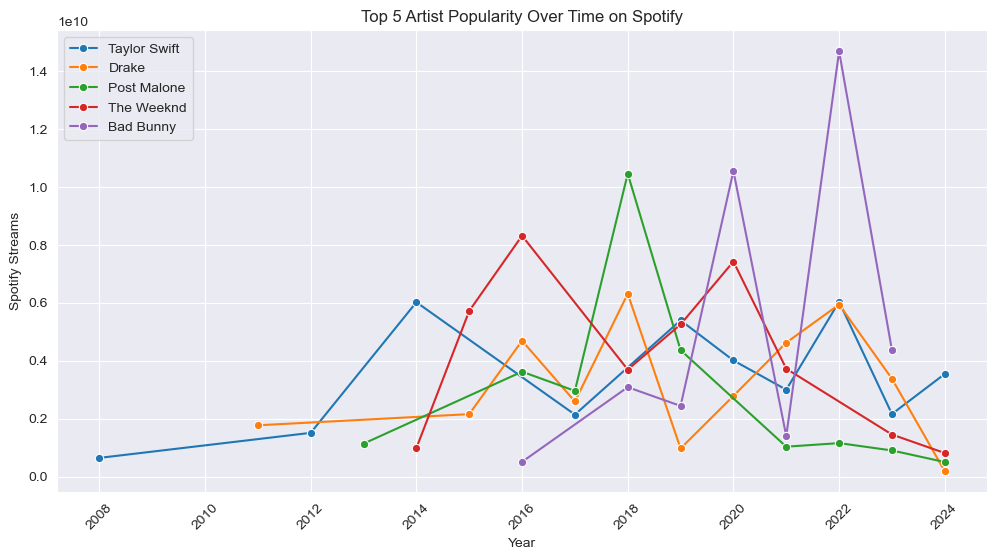

In [28]:
# Group by 'Artist', sum the 'Spotify Streams' for each artist, and get the top 5 artists
top_5_artists = features.groupby('Artist')['Spotify Streams'].sum().reset_index().sort_values(by='Spotify Streams', ascending=False).head(5)['Artist']

# Filter the dataset to include only the top 5 artists
filtered_features = features[features['Artist'].isin(top_5_artists)]

# Group by 'Year' and 'Artist', then sum up 'Spotify Streams' for the top 5 artists
artist_popularity = filtered_features.groupby(['Year', 'Artist'])['Spotify Streams'].sum().reset_index()

# Plotting the artist popularity over time for the top 5 artists
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Spotify Streams', hue='Artist', data=artist_popularity, marker='o')
plt.title('Top 5 Artist Popularity Over Time on Spotify')
plt.xlabel('Year')
plt.ylabel('Spotify Streams')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
